In [1]:
# ------- [Import all relevant libraries] -------

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Usual Suspects
import numpy as np           # Mathematical operations
import pandas as pd          # Data manipulation

# Visualization
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
import seaborn as sns

# String manipulation
import re

# Mathematical Operations
import math

# Pipelines
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

# ML
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, GridSearchCV, 
    StratifiedKFold, cross_val_score
)

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# ML Model Evaluation
import optuna
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, make_scorer, f1_score, 
    ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, 
    roc_auc_score, classification_report,
)

# Saving model for production
import joblib

# Handle class imbalance
from imblearn.over_sampling import SMOTE

# Display settings
pd.set_option('display.max_colwidth', None)
from IPython.display import display

# MODELING

Modeling will be carried out in three stages:

1. Baseline Modeling (Vanilla Iteration) – we will begin by training the classifier models using their default parameters. This establishes baseline performance benchmarks against which subsequent improvements can be evaluated.
2. Handling Class Imbalance – From the univariate analysis in the EDA phase, it is evident that the target variable is heavily imbalanced. To address this, we will apply class imbalance techniques such as SMOTE and class weighting before retraining the models.
3. Hyperparameter Tuning – After identifying the best-performing model(s), we will optimize them through hyperparameter tuning to enhance predictive performance and model robustness.

The classifiers selected are:
- Logistic Regression
- Random Forest
- XGBoost
- CatBoost

These models provide a strong comparative spectrum: 
- Logistic Regression offers interpretability and serves as a solid linear baseline
- Random Forest captures non-linear relationships and interactions
- XGBoost and CatBoost are powerful gradient boosting algorithms known for their superior performance on tabular data, especially in classification tasks.

## DATA PREPARATION

Key steps prior to modeling:

- Address multicollinearity by removing redundant and highly correlated features
- Separate target variable from feature set
- Encode the categorical variable (*state*)
- Scale numerical features
- Perform a final multicollinearity check using Variance Inflation Factor (VIF) before modeling

In [2]:
# Create a copy to avoid modifying original
data = pd.read_csv("../Data/modeling_data.csv")

# Create a copy
df = data.copy(deep=True)

# --- IDE ---

# Check dataset shape
print(f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

# Check columns
print('\n'+'=='*44)
print("Columns:")
display(df.columns)

# Check metadata
print('\n'+'=='*44)
print("Metadata Check:")
display(df.info())

# Check and remove duplicates
print('\n'+'=='*44)
print("Duplicates:", df.duplicated().sum())

# Drop duplicates
df.drop_duplicates(inplace=True)
print("Duplicates after dropping:", df.duplicated().sum())

# Check data completeness
print('\n'+'=='*44)
print("Missingness check:")
display(df.isna().sum())

The dataset has 3331 rows and 28 columns.

Columns:


Index(['state', 'account_length', 'area_code', 'intl_plan', 'voicemail_plan',
       'no_of_vmail_msgs', 'total_day_mins', 'total_day_calls',
       'total_day_charge', 'total_eve_mins', 'total_eve_calls',
       'total_eve_charge', 'total_night_mins', 'total_night_calls',
       'total_night_charge', 'total_intl_mins', 'total_intl_calls',
       'total_intl_charge', 'customer_service_calls', 'churn',
       'total_usage_mins', 'day_ratio', 'eve_ratio', 'night_ratio',
       'intl_ratio', 'custserv_per_month', 'active_vmail', 'avg_cost_per_min'],
      dtype='object')


Metadata Check:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3331 entries, 0 to 3330
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3331 non-null   object 
 1   account_length          3331 non-null   int64  
 2   area_code               3331 non-null   int64  
 3   intl_plan               3331 non-null   int64  
 4   voicemail_plan          3331 non-null   int64  
 5   no_of_vmail_msgs        3331 non-null   int64  
 6   total_day_mins          3331 non-null   float64
 7   total_day_calls         3331 non-null   int64  
 8   total_day_charge        3331 non-null   float64
 9   total_eve_mins          3331 non-null   float64
 10  total_eve_calls         3331 non-null   int64  
 11  total_eve_charge        3331 non-null   float64
 12  total_night_mins        3331 non-null   float64
 13  total_night_calls       3331 non-null   int64  
 14  total_night_charge     

None


Duplicates: 0
Duplicates after dropping: 0

Missingness check:


state                     0
account_length            0
area_code                 0
intl_plan                 0
voicemail_plan            0
no_of_vmail_msgs          0
total_day_mins            0
total_day_calls           0
total_day_charge          0
total_eve_mins            0
total_eve_calls           0
total_eve_charge          0
total_night_mins          0
total_night_calls         0
total_night_charge        0
total_intl_mins           0
total_intl_calls          0
total_intl_charge         0
customer_service_calls    0
churn                     0
total_usage_mins          0
day_ratio                 0
eve_ratio                 0
night_ratio               0
intl_ratio                0
custserv_per_month        0
active_vmail              0
avg_cost_per_min          0
dtype: int64

In [3]:
# Drop redundant features
# Features to remove due to perfect multicollinearity 
# or low predictive power
drop_features = [
    'total_day_charge',
    'total_eve_charge',
    'total_night_charge',
    'total_intl_charge',
    'total_usage_mins',
    'day_ratio',
    'eve_ratio',
    'night_ratio',
    'intl_ratio',
    'avg_cost_per_min',
    'area_code',
    'no_of_vmail_msgs', 
    'active_vmail'
]

df.drop(columns=drop_features, inplace=True)

In [4]:
# ------- [PREPROCESSING PIPELINE] -------

# Separate features and target
X = df.drop('churn', axis=1)
y = df['churn']

# Identify feature types
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Define preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(
        drop='first',
        sparse_output=False,
        handle_unknown='ignore'
    ))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='drop'
)

# Fit pipeline
X_processed = preprocessor.fit_transform(X)

# Extract transformed column names
encoded_cat_cols = preprocessor.named_transformers_['cat']['ohe'].get_feature_names_out(cat_cols)
processed_feature_names = num_cols + list(encoded_cat_cols)

# Convert to DataFrame
df_processed = pd.DataFrame(X_processed, columns=processed_feature_names)

# Compute VIF
df_vif = df_processed.copy()
df_vif['intercept'] = 1 

vif_df = pd.DataFrame({
    'feature': df_vif.columns,
    'VIF': [
        variance_inflation_factor(df_vif.values, i)
        for i in range(df_vif.shape[1])
    ]
})

display(vif_df.sort_values(by='VIF', ascending=False).reset_index(drop=True))

,feature,VIF
0,intercept,64.379840
1,state_WV,2.951988
2,state_MN,2.561322
3,state_NY,2.538082
4,state_AL,2.481712
...,...,...
59,total_intl_mins,1.018394
60,total_night_calls,1.016511
61,total_night_mins,1.016476
62,total_intl_calls,1.014197


## VANILLA ITERATION

,Model,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1,Test F1,Train ROC-AUC,Test ROC-AUC
0,Logistic Regression,0.867868,0.866567,0.843661,0.842057,0.867868,0.866567,0.841256,0.840692,0.832885,0.842811
1,Random Forest,1.000000,0.928036,1.000000,0.927237,1.000000,0.928036,1.000000,0.920432,1.000000,0.911051
2,XGBoost,1.000000,0.947526,1.000000,0.945745,1.000000,0.947526,1.000000,0.945668,1.000000,0.917779
3,CatBoost,0.981607,0.947526,0.981994,0.945788,0.981607,0.947526,0.981079,0.945392,0.996848,0.930982


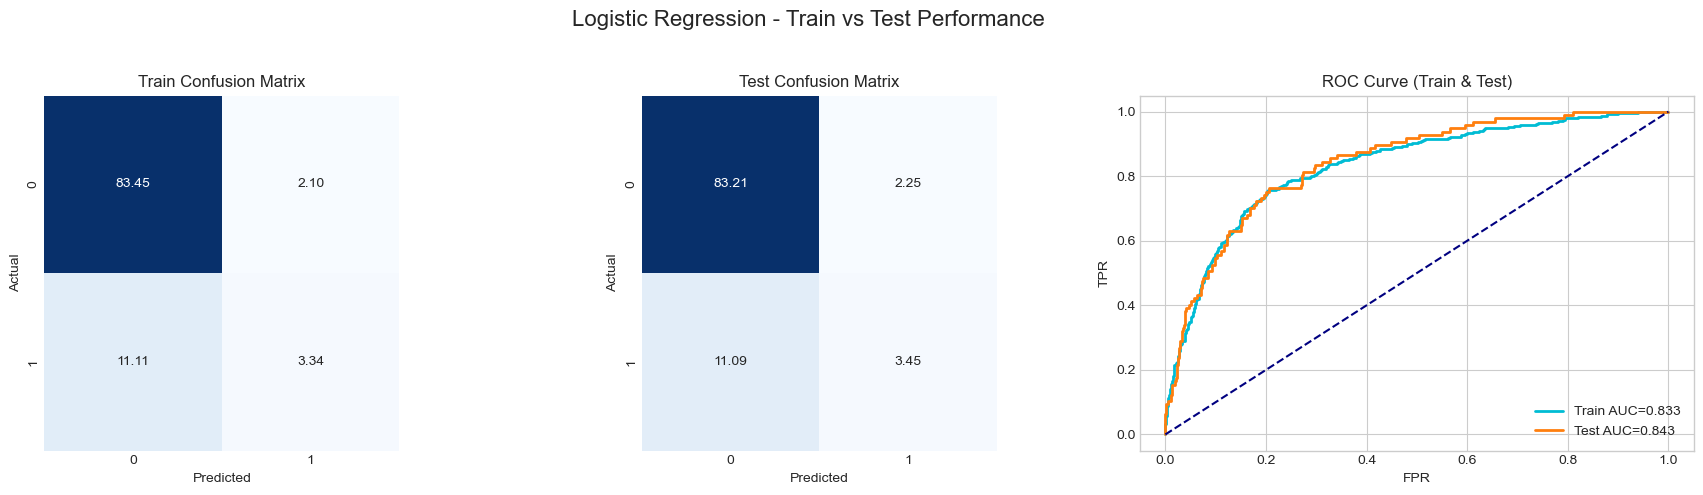

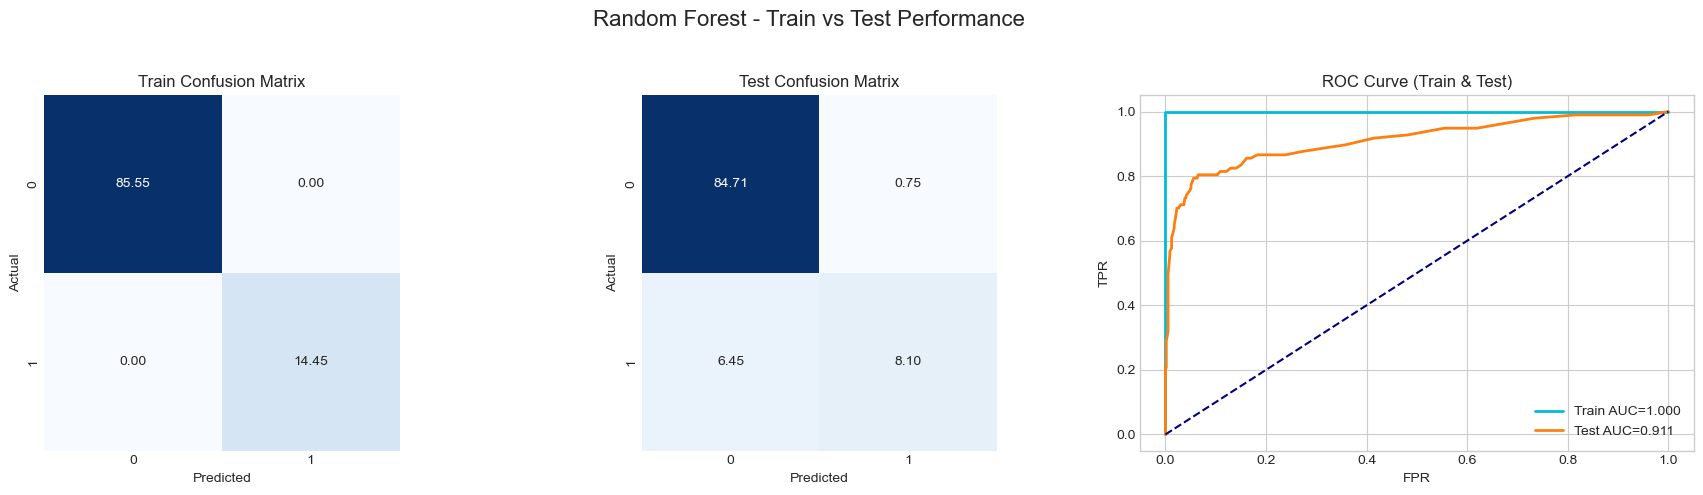

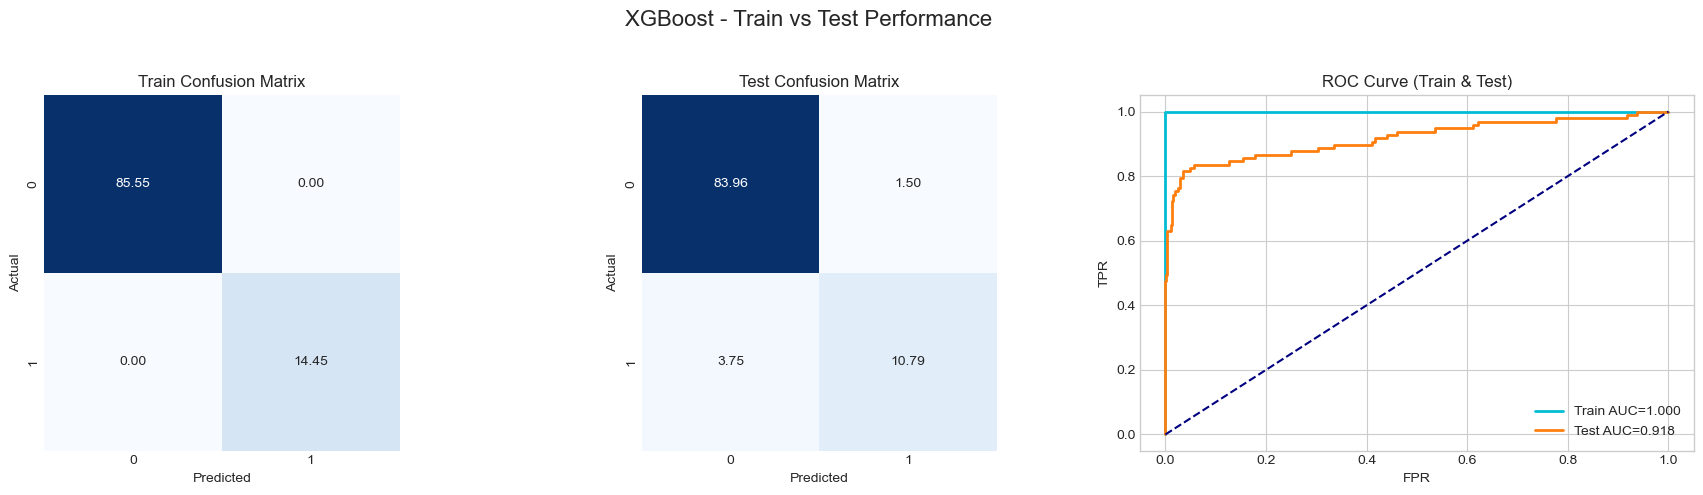

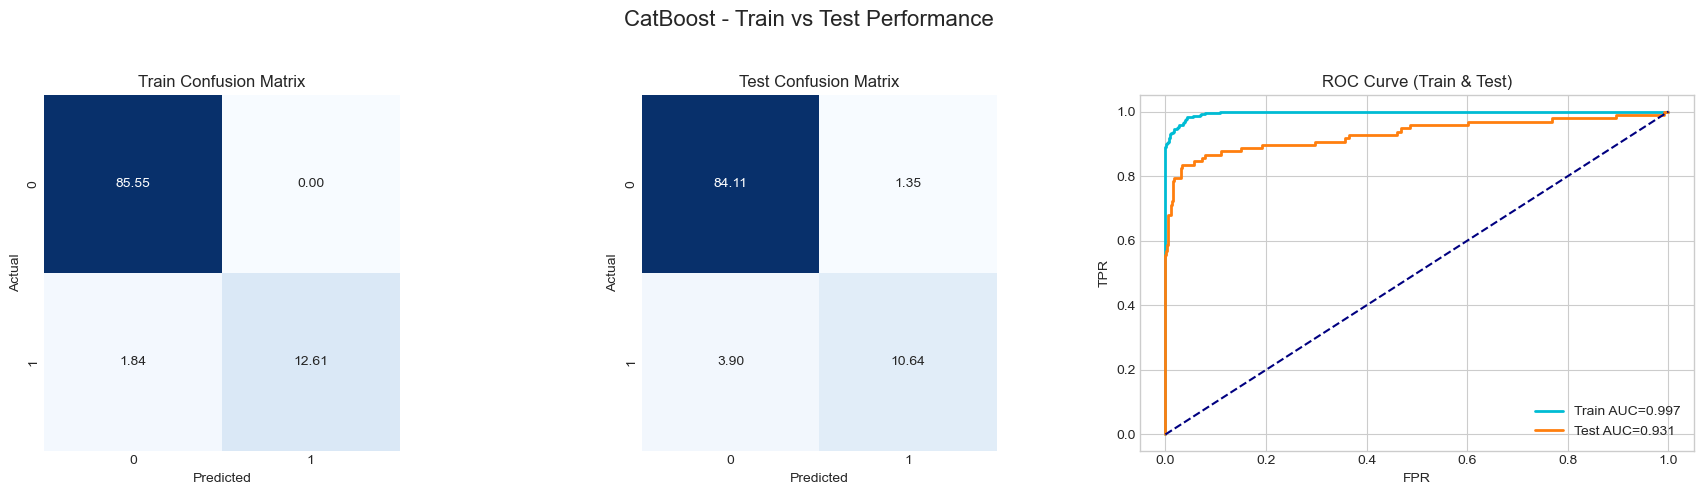

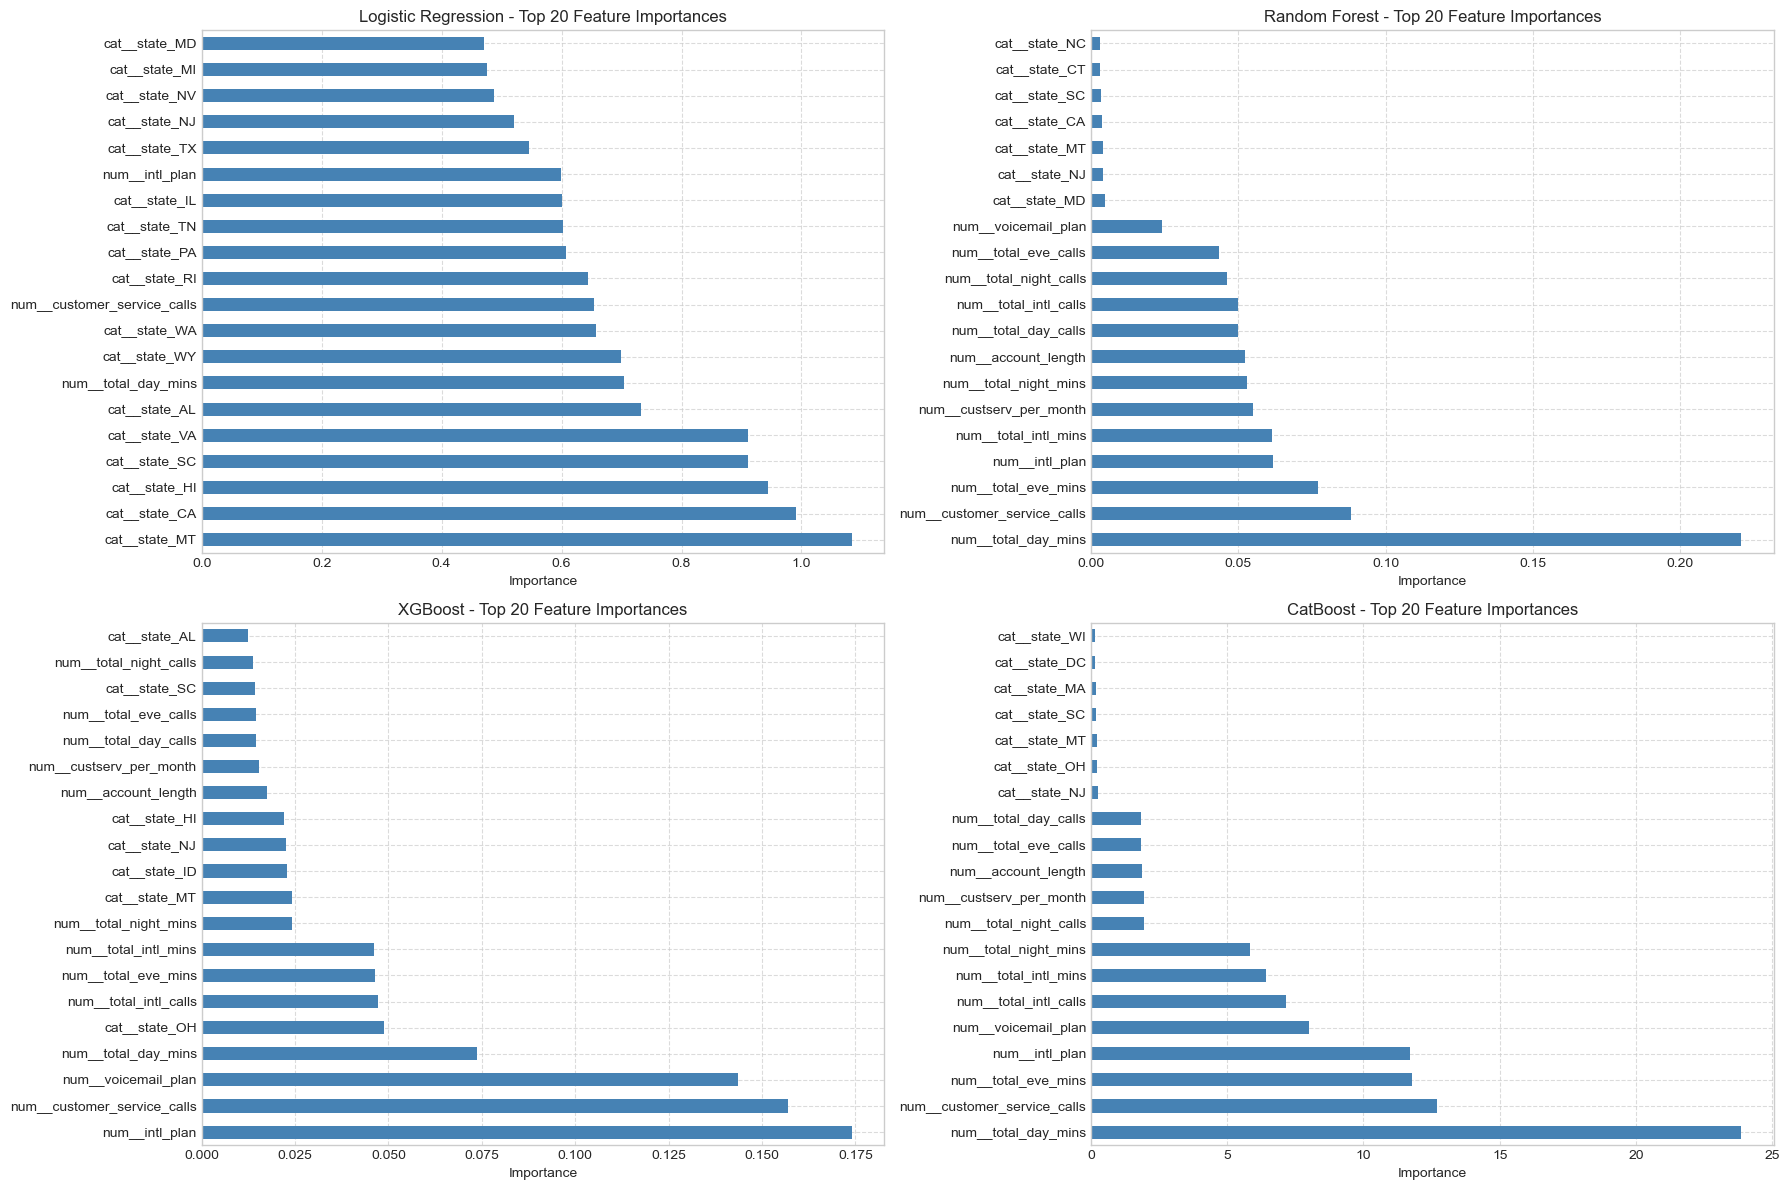

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define models 
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(
        random_state=42,
        silent=True,             
        eval_metric='Logloss'
    )
}


# Helper function to compute metrics
def compute_metrics(y_true, y_pred, y_prob):
    report = classification_report(y_true, y_pred, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    metrics = {
        'accuracy': report['accuracy'],
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1': report['weighted avg']['f1-score'],
        'roc_auc': roc_auc
    }
    return metrics, cm, (fpr, tpr, roc_auc)

# Containers
metrics_summary = []
plot_data = []
feature_importances = {}

# Fit models
for name, clf in models.items():

    pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('model', clf)
    ])
    
    pipeline.fit(X_train, y_train)

    # Predictions
    y_train_pred = pipeline.predict(X_train)
    y_test_pred  = pipeline.predict(X_test)

    # Probabilities
    if hasattr(clf, "predict_proba"):
        y_train_prob = pipeline.predict_proba(X_train)[:, 1]
        y_test_prob  = pipeline.predict_proba(X_test)[:, 1]
    else:
        y_train_prob = y_train_pred
        y_test_prob  = y_test_pred

    # Compute metrics
    train_metrics, train_cm, train_roc = compute_metrics(y_train, y_train_pred, y_train_prob)
    test_metrics, test_cm, test_roc   = compute_metrics(y_test, y_test_pred, y_test_prob)

    metrics_summary.append({
        'Model': name,
        'Train Accuracy': train_metrics['accuracy'],
        'Test Accuracy': test_metrics['accuracy'],
        'Train Precision': train_metrics['precision'],
        'Test Precision': test_metrics['precision'],
        'Train Recall': train_metrics['recall'],
        'Test Recall': test_metrics['recall'],
        'Train F1': train_metrics['f1'],
        'Test F1': test_metrics['f1'],
        'Train ROC-AUC': train_metrics['roc_auc'],
        'Test ROC-AUC': test_metrics['roc_auc']
    })

    # Save plot data
    plot_data.append((name, train_cm, test_cm, train_roc, test_roc))

    # Feature importances
    final_model = pipeline.named_steps['model']
    try:
        # CatBoost
        if name == 'CatBoost':
            importances = pd.Series(final_model.get_feature_importance(), 
                                    index=pipeline.named_steps['preprocess'].get_feature_names_out())
            importances = importances.sort_values(ascending=False).head(20)

        # Tree-based models
        elif hasattr(final_model, 'feature_importances_'):
            feature_names = pipeline.named_steps['preprocess'].get_feature_names_out()
            importances = pd.Series(final_model.feature_importances_, index=feature_names)\
                            .sort_values(ascending=False).head(20)

        # Linear models
        elif hasattr(final_model, 'coef_'):
            feature_names = pipeline.named_steps['preprocess'].get_feature_names_out()
            coef = np.abs(final_model.coef_).ravel()
            importances = pd.Series(coef, index=feature_names).sort_values(ascending=False).head(20)

        else:
            feature_names = pipeline.named_steps['preprocess'].get_feature_names_out()
            importances = pd.Series([0]*len(feature_names), index=feature_names)

    except:
        feature_names = pipeline.named_steps['preprocess'].get_feature_names_out()
        importances = pd.Series([0]*len(feature_names), index=feature_names)

    feature_importances[name] = importances


# Display metrics
metrics_df = pd.DataFrame(metrics_summary)
metrics_df = metrics_df[['Model','Train Accuracy','Test Accuracy',
                         'Train Precision','Test Precision',
                         'Train Recall','Test Recall',
                         'Train F1','Test F1',
                         'Train ROC-AUC','Test ROC-AUC']]
display(metrics_df)

# Confusion matrices & ROC curves
for name, train_cm, test_cm, train_roc, test_roc in plot_data:
    fig, axes = plt.subplots(1, 3, figsize=(18,5))
    fig.suptitle(f"{name} - Train vs Test Performance", fontsize=16)
    
    train_cm_pct = train_cm / train_cm.sum() * 100
    test_cm_pct  = test_cm / test_cm.sum() * 100
    
    sns.heatmap(train_cm_pct, annot=True, fmt=".2f", cmap='Blues', cbar=False, square=True, ax=axes[0])
    axes[0].set(title='Train Confusion Matrix', xlabel='Predicted', ylabel='Actual')
    
    sns.heatmap(test_cm_pct, annot=True, fmt=".2f", cmap='Blues', cbar=False, square=True, ax=axes[1])
    axes[1].set(title='Test Confusion Matrix', xlabel='Predicted', ylabel='Actual')
    
    ax = axes[2]
    fpr_train, tpr_train, auc_train = train_roc
    fpr_test, tpr_test, auc_test = test_roc
    ax.plot(fpr_train, tpr_train, lw=2, label=f'Train AUC={auc_train:.3f}', color='#00bcd4')
    ax.plot(fpr_test, tpr_test, lw=2, label=f'Test AUC={auc_test:.3f}', color='#ff7f0e')
    ax.plot([0,1],[0,1],'--', color='navy')
    ax.set(title='ROC Curve (Train & Test)', xlabel='FPR', ylabel='TPR')
    ax.legend(loc='lower right')
    
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

# Feature importance plots
rows, cols = 2, 2
fig, axes = plt.subplots(rows, cols, figsize=(18,12))
axes = axes.flatten()

for i, (name, importances) in enumerate(feature_importances.items()):
    importances.sort_values().plot(kind='barh', ax=axes[i], color='steelblue')
    axes[i].set_title(f"{name} - Top 20 Feature Importances", fontsize=12)
    axes[i].set_xlabel('Importance')
    axes[i].invert_yaxis()
    axes[i].grid(axis='both', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## DEALING WITH CLASS IMBALANCE

### USING CLASS WEIGHTS

,Model,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1,Test F1,Train ROC-AUC,Test ROC-AUC
0,Logistic Regression,0.775526,0.751124,0.869524,0.864346,0.775526,0.751124,0.803992,0.784460,0.838791,0.839248
1,Random Forest,1.000000,0.899550,1.000000,0.895818,1.000000,0.899550,1.000000,0.881989,1.000000,0.914605
2,CatBoost,0.981607,0.947526,0.981994,0.945788,0.981607,0.947526,0.981079,0.945392,0.996848,0.930982
3,XGBoost,1.000000,0.944528,1.000000,0.943179,1.000000,0.944528,1.000000,0.943659,1.000000,0.922391


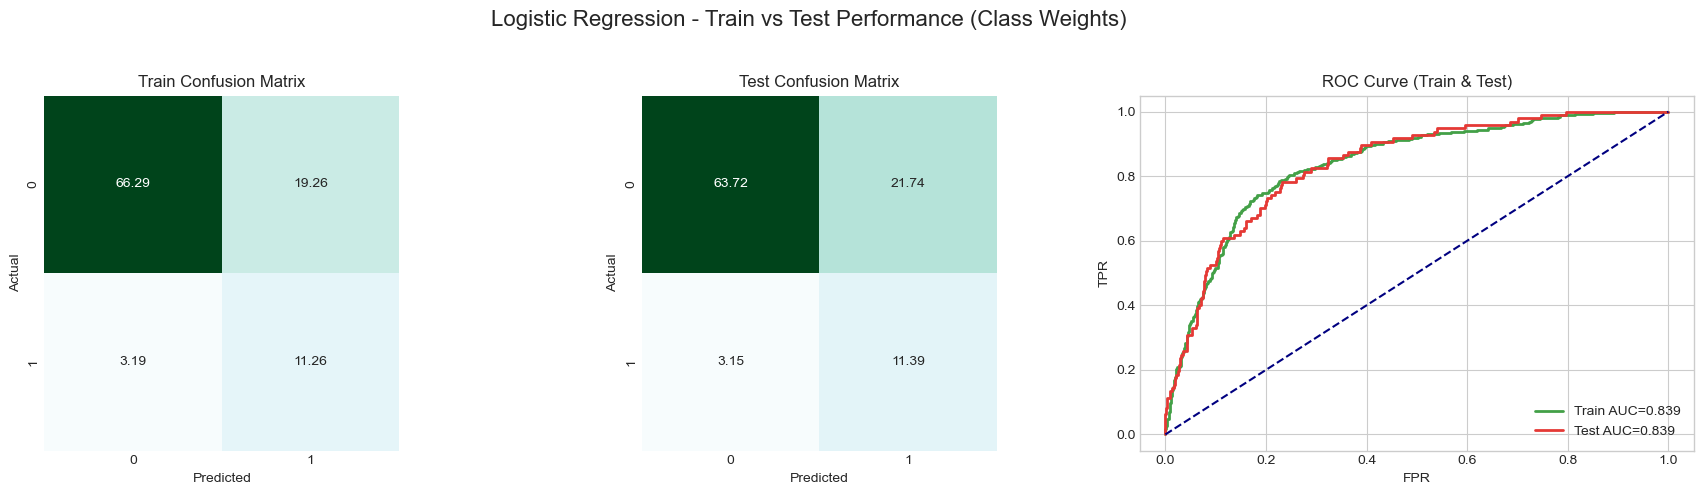

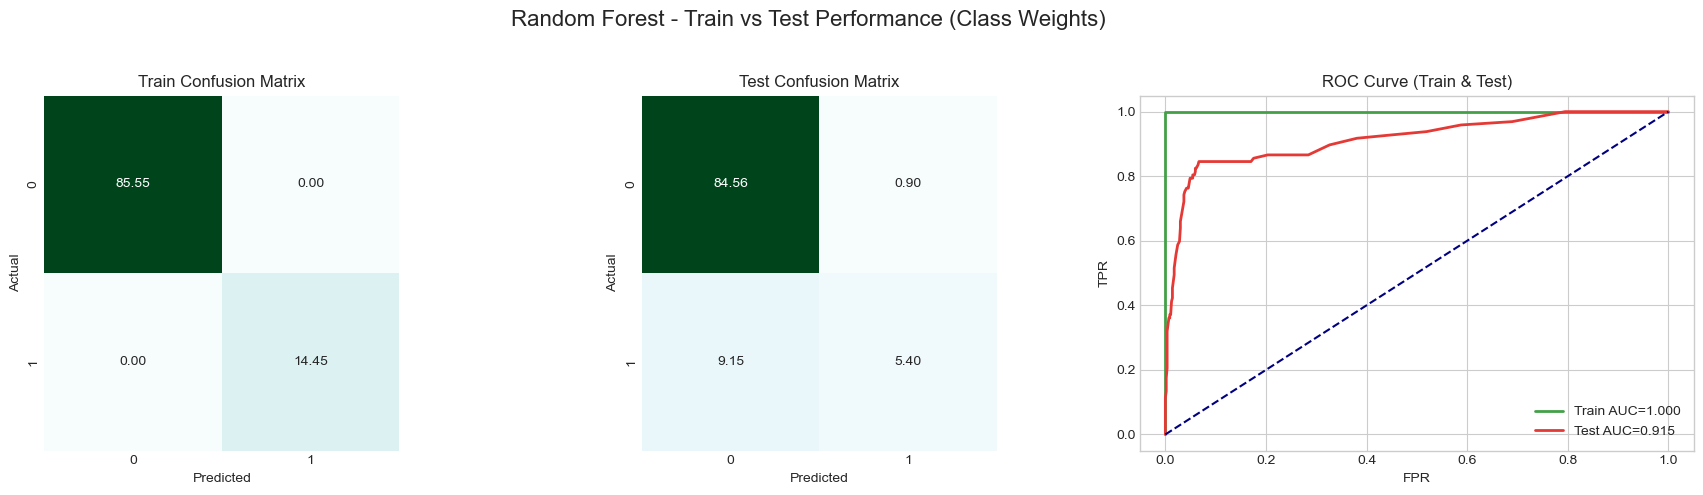

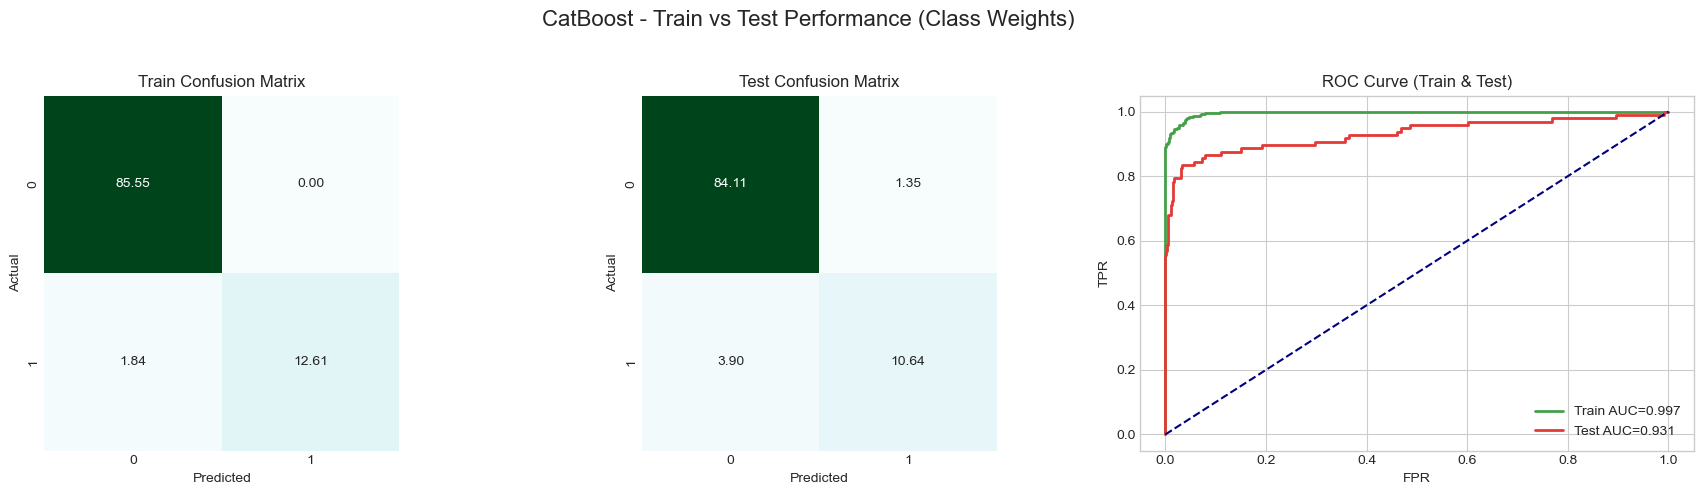

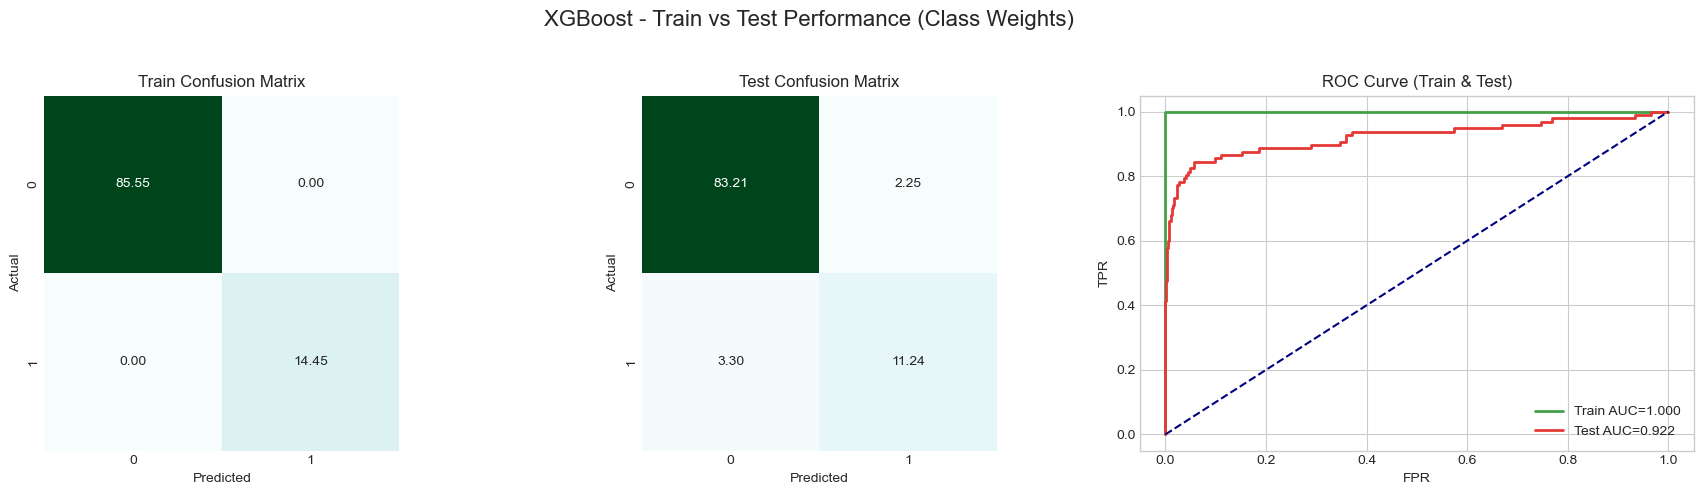

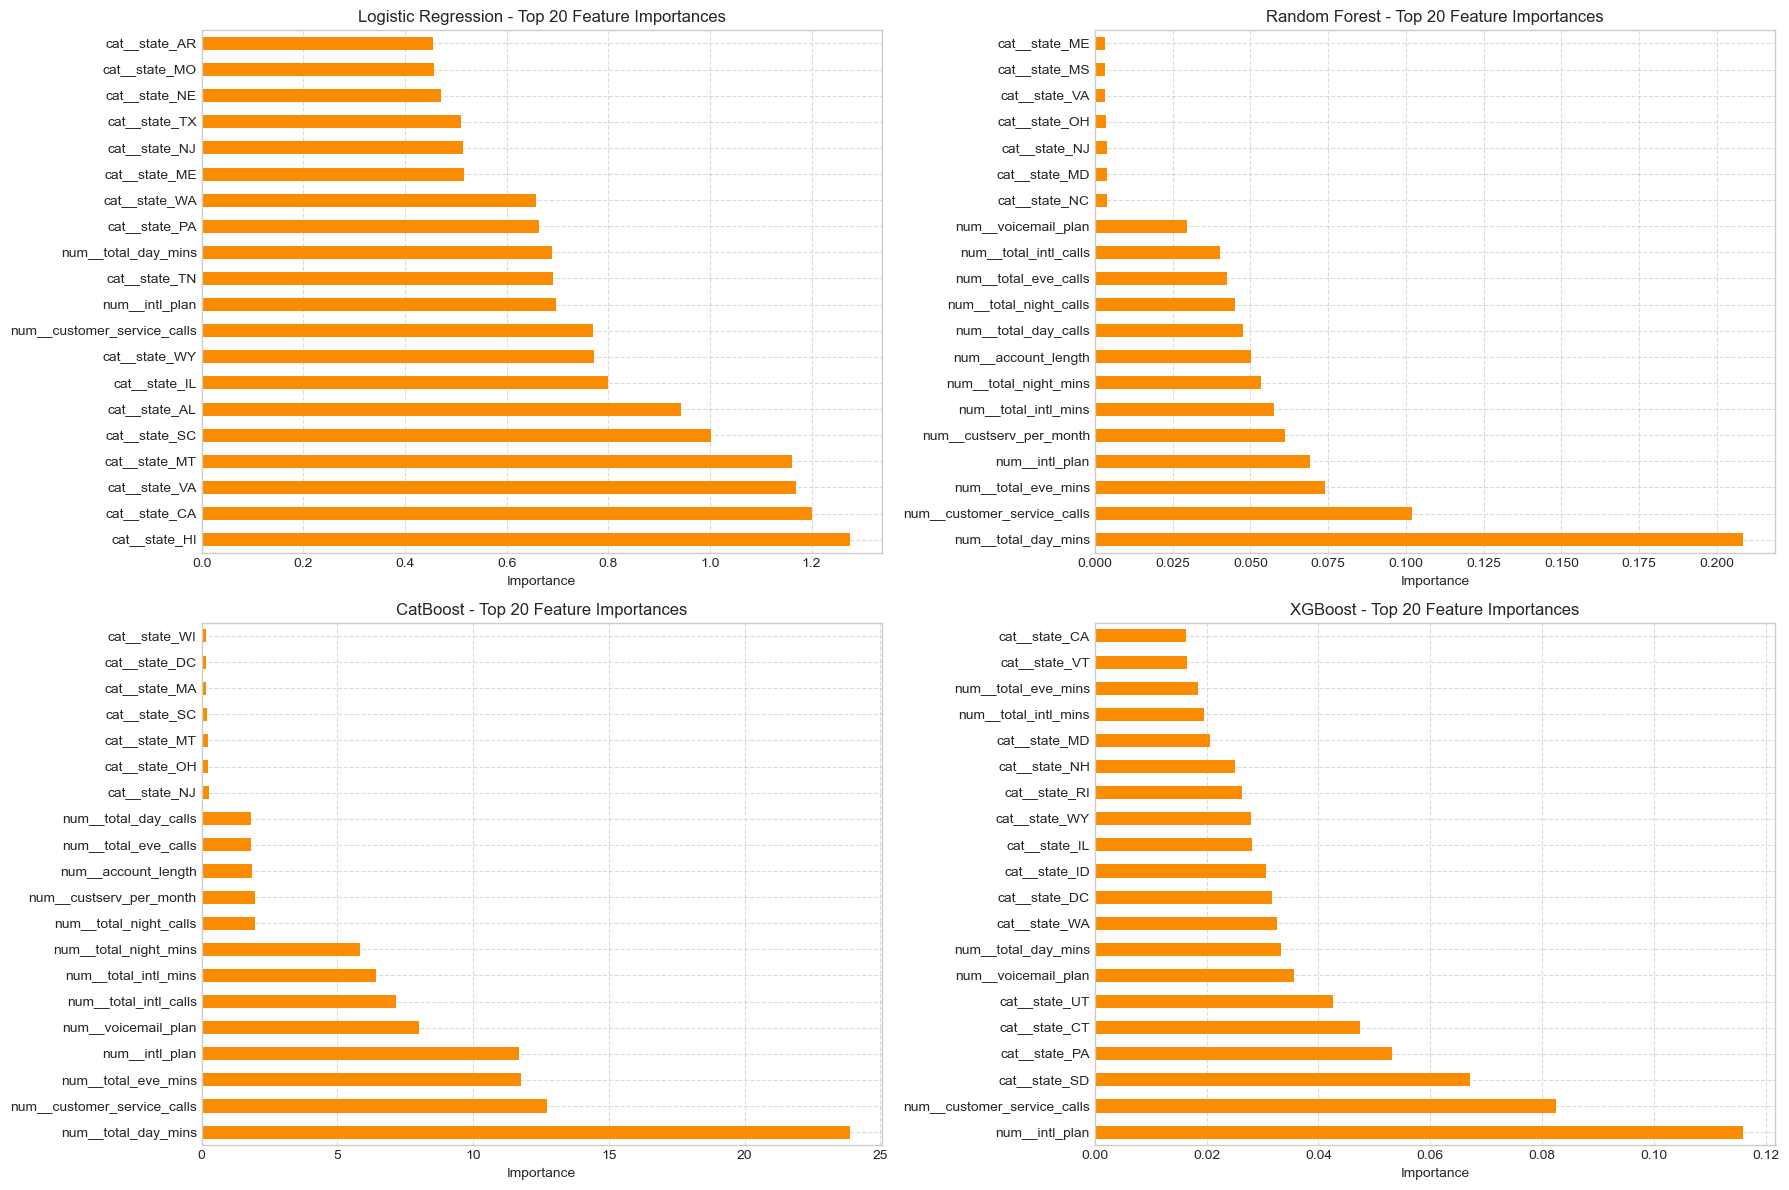

In [9]:
# Compute XGBoost scale_pos_weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Define models with class weighting
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'CatBoost': CatBoostClassifier(
        random_state=42,
        silent=True,
        eval_metric='Logloss'
    ),
    'XGBoost': XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight
    )
}

# Helper function to compute metrics
def compute_metrics(y_true, y_pred, y_prob):
    report = classification_report(y_true, y_pred, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    metrics = {
        'accuracy': report['accuracy'],
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1': report['weighted avg']['f1-score'],
        'roc_auc': roc_auc
    }
    return metrics, cm, (fpr, tpr, roc_auc)

# Containers
metrics_summary = []
plot_data = []
feature_importances = {}

# Fit models and compute metrics
for name, clf in models.items():
    
    pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('model', clf)
    ])
    
    pipeline.fit(X_train, y_train)
    
    # Predictions & probabilities
    y_train_pred = pipeline.predict(X_train)
    y_test_pred  = pipeline.predict(X_test)
    
    if hasattr(clf, "predict_proba"):
        y_train_prob = pipeline.predict_proba(X_train)[:,1]
        y_test_prob  = pipeline.predict_proba(X_test)[:,1]
    elif hasattr(clf, "decision_function"):
        y_train_prob = pipeline.decision_function(X_train)
        y_test_prob  = pipeline.decision_function(X_test)
    else:
        y_train_prob = y_train_pred
        y_test_prob  = y_test_pred
    
    # Metrics
    train_metrics, train_cm, train_roc = compute_metrics(y_train, y_train_pred, y_train_prob)
    test_metrics, test_cm, test_roc   = compute_metrics(y_test, y_test_pred, y_test_prob)
    
    # Save metrics
    metrics_summary.append({
        'Model': name,
        'Train Accuracy': train_metrics['accuracy'],
        'Test Accuracy': test_metrics['accuracy'],
        'Train Precision': train_metrics['precision'],
        'Test Precision': test_metrics['precision'],
        'Train Recall': train_metrics['recall'],
        'Test Recall': test_metrics['recall'],
        'Train F1': train_metrics['f1'],
        'Test F1': test_metrics['f1'],
        'Train ROC-AUC': train_metrics['roc_auc'],
        'Test ROC-AUC': test_metrics['roc_auc']
    })
    
    # Save plot data
    plot_data.append((name, train_cm, test_cm, train_roc, test_roc))
    
    # FEATURE IMPORTANCES
    final_model = pipeline.named_steps['model']
    
    feature_names = pipeline.named_steps['preprocess'].get_feature_names_out()
    
    try:
        if name == 'CatBoost':
            importances = pd.Series(final_model.get_feature_importance(), index=feature_names)\
                          .sort_values(ascending=False)[:20]
        elif hasattr(final_model, 'feature_importances_'):
            importances = pd.Series(final_model.feature_importances_, index=feature_names)\
                          .sort_values(ascending=False)[:20]
        elif hasattr(final_model, 'coef_'):
            importances = pd.Series(np.abs(final_model.coef_[0]), index=feature_names)\
                          .sort_values(ascending=False)[:20]
        else:
            importances = pd.Series([0]*len(feature_names), index=feature_names)
    except:
        importances = pd.Series([0]*len(feature_names), index=feature_names)
    
    feature_importances[name] = importances

# Display metrics
metrics_df = pd.DataFrame(metrics_summary)
metrics_df = metrics_df[['Model','Train Accuracy','Test Accuracy',
                         'Train Precision','Test Precision',
                         'Train Recall','Test Recall',
                         'Train F1','Test F1',
                         'Train ROC-AUC','Test ROC-AUC']]
display(metrics_df)

# Plot confusion matrices & ROC curves
for name, train_cm, test_cm, train_roc, test_roc in plot_data:
    fig, axes = plt.subplots(1, 3, figsize=(18,5))
    fig.suptitle(f"{name} - Train vs Test Performance (Class Weights)", fontsize=16)
    
    train_cm_pct = train_cm / train_cm.sum() * 100
    test_cm_pct  = test_cm / test_cm.sum() * 100
    
    sns.heatmap(train_cm_pct, annot=True, fmt=".2f", cmap='BuGn', cbar=False, square=True, ax=axes[0])
    axes[0].set(title='Train Confusion Matrix', xlabel='Predicted', ylabel='Actual')
    
    sns.heatmap(test_cm_pct, annot=True, fmt=".2f", cmap='BuGn', cbar=False, square=True, ax=axes[1])
    axes[1].set(title='Test Confusion Matrix', xlabel='Predicted', ylabel='Actual')
    
    ax = axes[2]
    fpr_train, tpr_train, auc_train = train_roc
    fpr_test, tpr_test, auc_test = test_roc
    ax.plot(fpr_train, tpr_train, lw=2, label=f'Train AUC={auc_train:.3f}', color='#43a047')
    ax.plot(fpr_test, tpr_test, lw=2, label=f'Test AUC={auc_test:.3f}', color='#e53935')
    ax.plot([0,1],[0,1],'--', color='navy')
    ax.set(title='ROC Curve (Train & Test)', xlabel='FPR', ylabel='TPR')
    ax.legend(loc='lower right')
    
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

# Plot top 20 feature importances
rows, cols = 2, 2
fig, axes = plt.subplots(rows, cols, figsize=(18,12))
axes = axes.flatten()

for i, (name, importances) in enumerate(feature_importances.items()):
    importances.sort_values().plot(kind='barh', ax=axes[i], color='#fb8c00')
    axes[i].set_title(f"{name} - Top 20 Feature Importances", fontsize=12)
    axes[i].set_xlabel('Importance')
    axes[i].invert_yaxis()
    axes[i].grid(axis='both', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### USING SMOTE

,Model,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1,Test F1,Train ROC-AUC,Test ROC-AUC
0,Logistic Regression,0.777402,0.758621,0.868106,0.862137,0.777402,0.758621,0.805232,0.789997,0.833873,0.828396
1,Random Forest,1.000000,0.920540,1.000000,0.917889,1.000000,0.920540,1.000000,0.918918,1.000000,0.900859
2,CatBoost,0.983859,0.943028,0.984033,0.941790,0.983859,0.943028,0.983497,0.942269,0.998806,0.924616
3,XGBoost,1.000000,0.940030,1.000000,0.938372,1.000000,0.940030,1.000000,0.938949,1.000000,0.921306


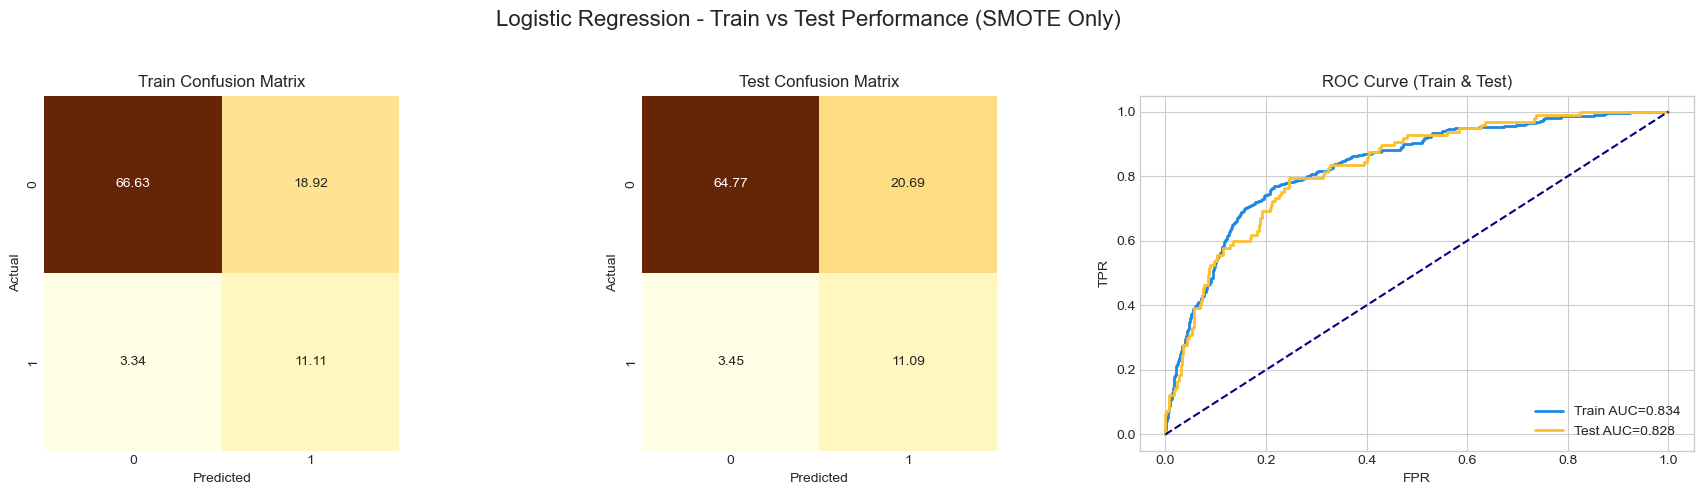

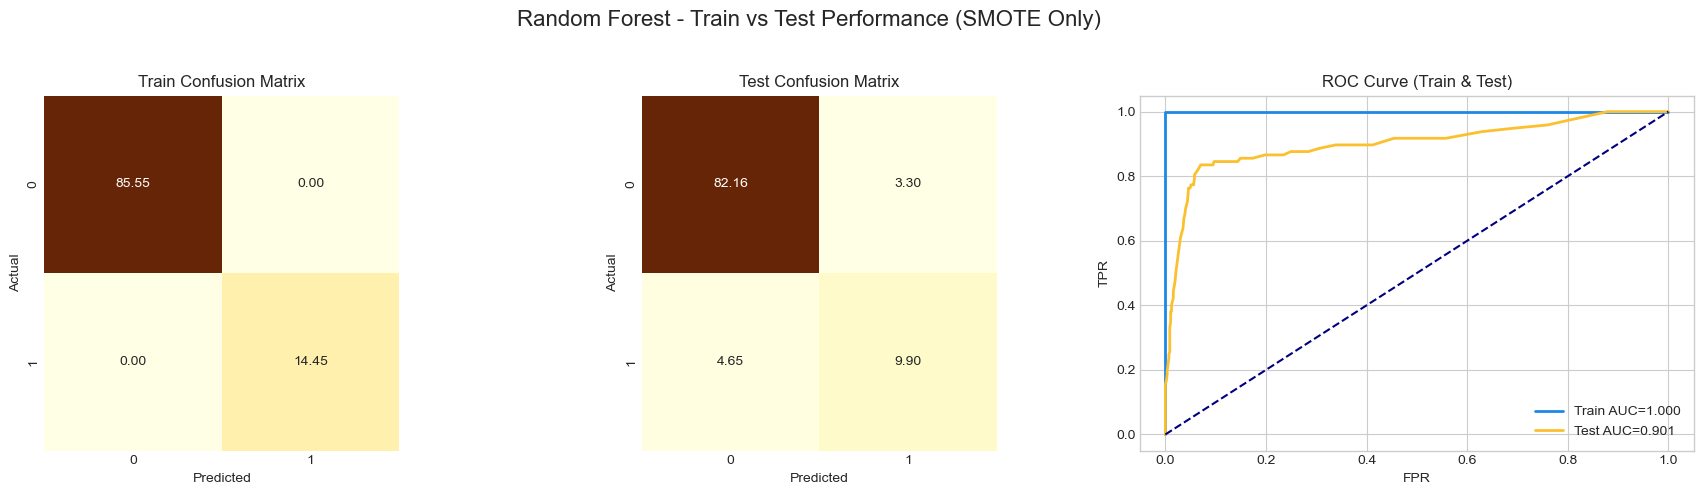

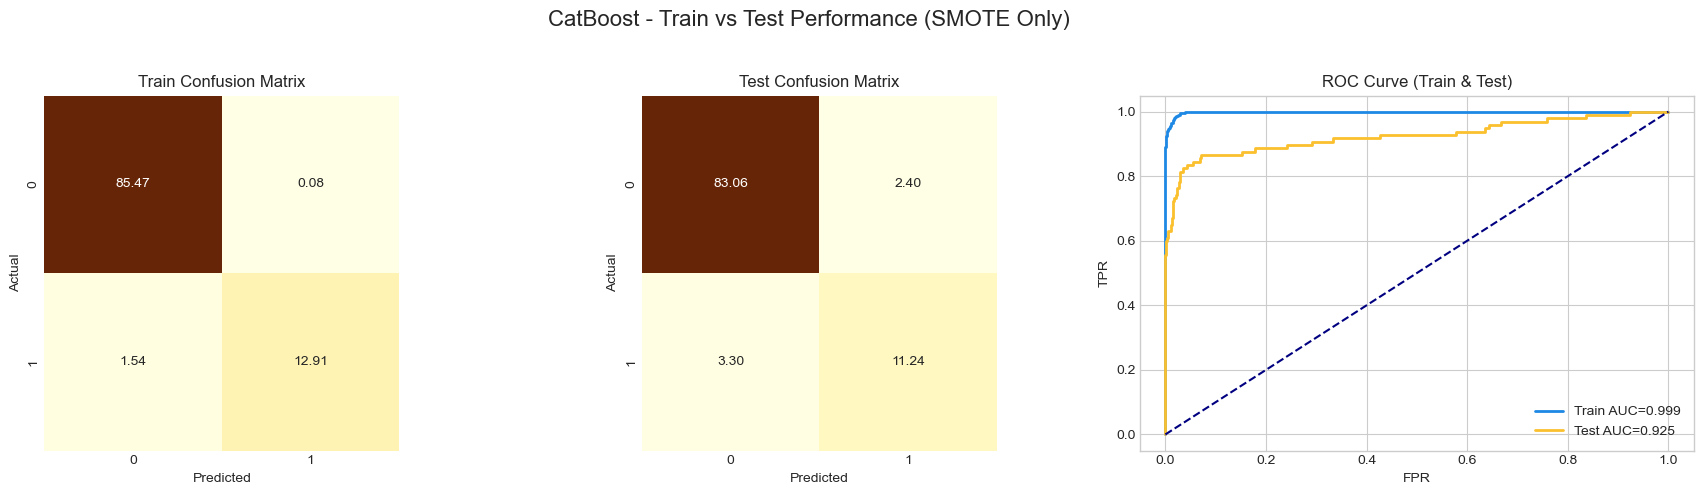

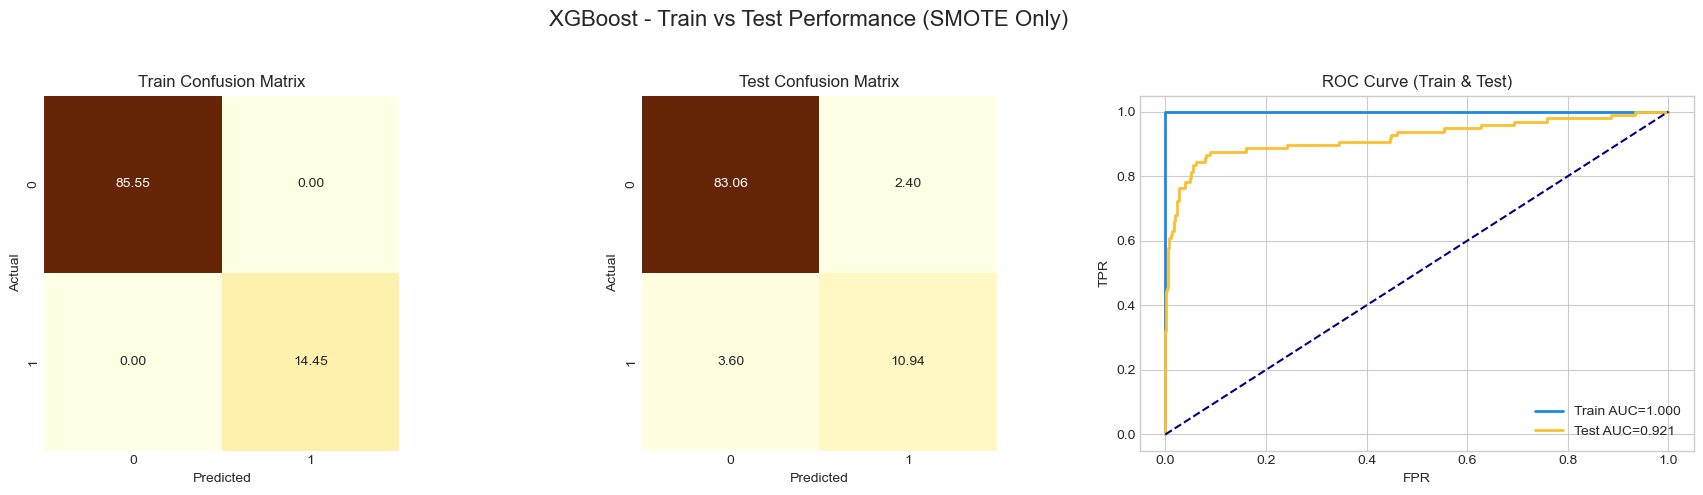

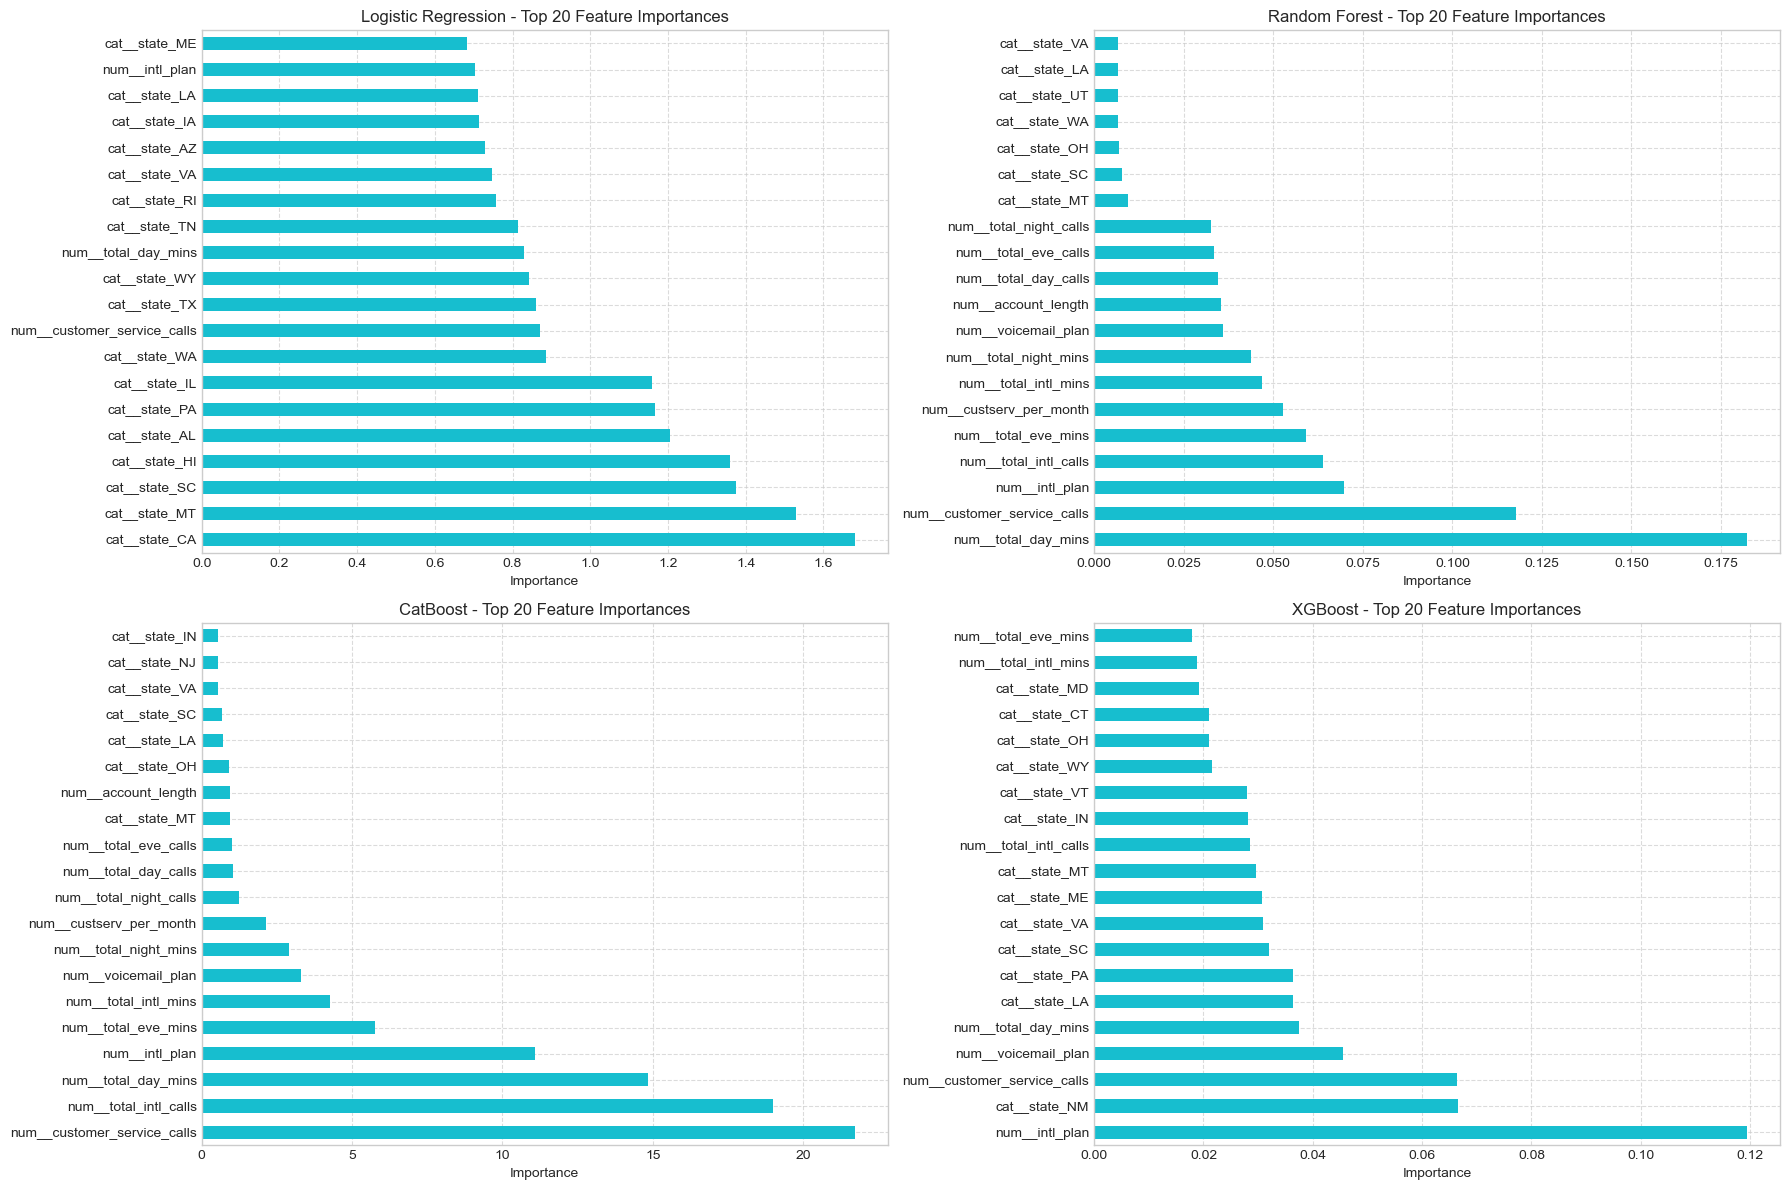

In [10]:
# Define models 
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(
        random_state=42,
        silent=True,
        eval_metric='Logloss'
    ),
    'XGBoost': XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )
}

# Helper function to compute metrics
def compute_metrics(y_true, y_pred, y_prob):
    report = classification_report(y_true, y_pred, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    metrics = {
        'accuracy': report['accuracy'],
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1': report['weighted avg']['f1-score'],
        'roc_auc': roc_auc
    }
    return metrics, cm, (fpr, tpr, roc_auc)

# Containers
metrics_summary = []
plot_data = []
feature_importances = {}

# Fit models with SMOTE and compute metrics
for name, clf in models.items():
    
    # Imbalanced pipeline with SMOTE
    pipeline = ImbPipeline([
        ('preprocess', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('model', clf)
    ])
    
    pipeline.fit(X_train, y_train)
    
    # Predictions & probabilities
    y_train_pred = pipeline.predict(X_train)
    y_test_pred  = pipeline.predict(X_test)
    
    if hasattr(clf, "predict_proba"):
        y_train_prob = pipeline.predict_proba(X_train)[:,1]
        y_test_prob  = pipeline.predict_proba(X_test)[:,1]
    elif hasattr(clf, "decision_function"):
        y_train_prob = pipeline.decision_function(X_train)
        y_test_prob  = pipeline.decision_function(X_test)
    else:
        y_train_prob = y_train_pred
        y_test_prob  = y_test_pred
    
    # Metrics
    train_metrics, train_cm, train_roc = compute_metrics(y_train, y_train_pred, y_train_prob)
    test_metrics, test_cm, test_roc   = compute_metrics(y_test, y_test_pred, y_test_prob)
    
    # Save metrics
    metrics_summary.append({
        'Model': name,
        'Train Accuracy': train_metrics['accuracy'],
        'Test Accuracy': test_metrics['accuracy'],
        'Train Precision': train_metrics['precision'],
        'Test Precision': test_metrics['precision'],
        'Train Recall': train_metrics['recall'],
        'Test Recall': test_metrics['recall'],
        'Train F1': train_metrics['f1'],
        'Test F1': test_metrics['f1'],
        'Train ROC-AUC': train_metrics['roc_auc'],
        'Test ROC-AUC': test_metrics['roc_auc']
    })
    
    # Save plot data
    plot_data.append((name, train_cm, test_cm, train_roc, test_roc))
    
    # FEATURE IMPORTANCES
    final_model = pipeline.named_steps['model']
    
    # get feature names from pipeline
    feature_names = pipeline.named_steps['preprocess'].get_feature_names_out()
    
    try:
        if name == 'CatBoost':
            importances = pd.Series(final_model.get_feature_importance(), index=feature_names)\
                          .sort_values(ascending=False)[:20]
        elif hasattr(final_model, 'feature_importances_'):
            importances = pd.Series(final_model.feature_importances_, index=feature_names)\
                          .sort_values(ascending=False)[:20]
        elif hasattr(final_model, 'coef_'):
            importances = pd.Series(np.abs(final_model.coef_[0]), index=feature_names)\
                          .sort_values(ascending=False)[:20]
        else:
            importances = pd.Series([0]*len(feature_names), index=feature_names)
    except:
        importances = pd.Series([0]*len(feature_names), index=feature_names)
    
    feature_importances[name] = importances

# Display metrics table
metrics_df = pd.DataFrame(metrics_summary)
metrics_df = metrics_df[['Model','Train Accuracy','Test Accuracy',
                         'Train Precision','Test Precision',
                         'Train Recall','Test Recall',
                         'Train F1','Test F1',
                         'Train ROC-AUC','Test ROC-AUC']]
display(metrics_df)

# Plot confusion matrices & ROC curves
for name, train_cm, test_cm, train_roc, test_roc in plot_data:
    fig, axes = plt.subplots(1, 3, figsize=(18,5))
    fig.suptitle(f"{name} - Train vs Test Performance (SMOTE Only)", fontsize=16)
    
    train_cm_pct = train_cm / train_cm.sum() * 100
    test_cm_pct  = test_cm / test_cm.sum() * 100
    
    sns.heatmap(train_cm_pct, annot=True, fmt=".2f", cmap='YlOrBr', cbar=False, square=True, ax=axes[0])
    axes[0].set(title='Train Confusion Matrix', xlabel='Predicted', ylabel='Actual')
    
    sns.heatmap(test_cm_pct, annot=True, fmt=".2f", cmap='YlOrBr', cbar=False, square=True, ax=axes[1])
    axes[1].set(title='Test Confusion Matrix', xlabel='Predicted', ylabel='Actual')
    
    ax = axes[2]
    fpr_train, tpr_train, auc_train = train_roc
    fpr_test, tpr_test, auc_test = test_roc
    ax.plot(fpr_train, tpr_train, lw=2, label=f'Train AUC={auc_train:.3f}', color='#1e88e5')
    ax.plot(fpr_test, tpr_test, lw=2, label=f'Test AUC={auc_test:.3f}', color='#fbc02d')
    ax.plot([0,1],[0,1],'--', color='navy')
    ax.set(title='ROC Curve (Train & Test)', xlabel='FPR', ylabel='TPR')
    ax.legend(loc='lower right')
    
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

# Plot top 20 feature importances
rows, cols = 2, 2
fig, axes = plt.subplots(rows, cols, figsize=(18,12))
axes = axes.flatten()

for i, (name, importances) in enumerate(feature_importances.items()):
    importances.sort_values().plot(kind='barh', ax=axes[i], color='#17becf')
    axes[i].set_title(f"{name} - Top 20 Feature Importances", fontsize=12)
    axes[i].set_xlabel('Importance')
    axes[i].invert_yaxis()
    axes[i].grid(axis='both', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## HYPERPARAMETER TUNING

[I 2025-11-27 15:42:41,739] A new study created in memory with name: no-name-0c354bc6-5da1-43f8-a714-7481c3c557a2


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-27 15:42:43,004] Trial 0 finished with value: 0.7298578199052133 and parameters: {'iterations': 250, 'depth': 2, 'learning_rate': 0.28208063682984097, 'l2_leaf_reg': 1, 'bagging_temperature': 0.2773253829515149}. Best is trial 0 with value: 0.7298578199052133.
[I 2025-11-27 15:42:44,083] Trial 1 finished with value: 0.7960199004975125 and parameters: {'iterations': 150, 'depth': 5, 'learning_rate': 0.20125654640676452, 'l2_leaf_reg': 9, 'bagging_temperature': 0.8104740927887935}. Best is trial 1 with value: 0.7960199004975125.
[I 2025-11-27 15:42:45,976] Trial 2 finished with value: 0.7918781725888325 and parameters: {'iterations': 150, 'depth': 8, 'learning_rate': 0.14523898541181474, 'l2_leaf_reg': 8, 'bagging_temperature': 0.16919325955994757}. Best is trial 1 with value: 0.7960199004975125.
[I 2025-11-27 15:42:46,714] Trial 3 finished with value: 0.6804979253112033 and parameters: {'iterations': 150, 'depth': 2, 'learning_rate': 0.07879713083004547, 'l2_leaf_reg': 2, 'ba

,Model,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1,Test F1,Train ROC-AUC,Test ROC-AUC
0,RandomizedSearchCV,0.997748,0.934033,0.997782,0.934033,0.997748,0.934033,0.997755,0.934033,0.999986,0.927925
1,Optuna,0.999625,0.947526,0.999626,0.947757,0.999625,0.947526,0.999625,0.947638,1.000000,0.928450
2,GridSearchCV,1.000000,0.941529,1.000000,0.941285,1.000000,0.941529,1.000000,0.941403,1.000000,0.931181


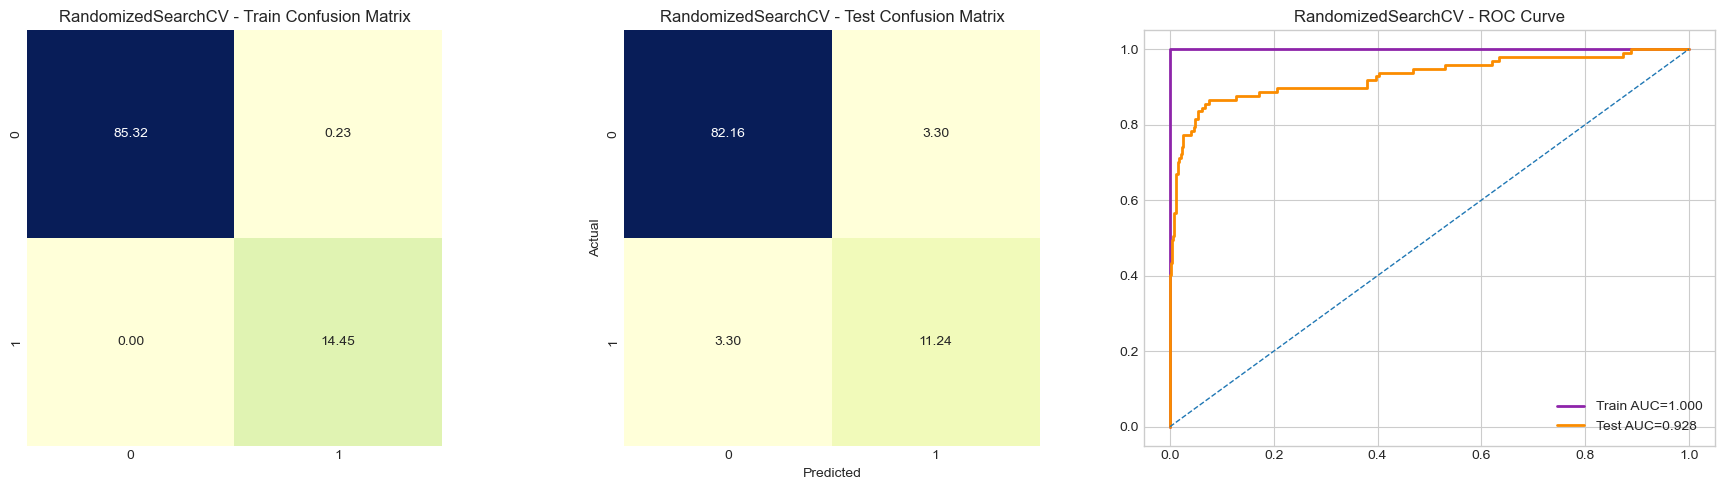

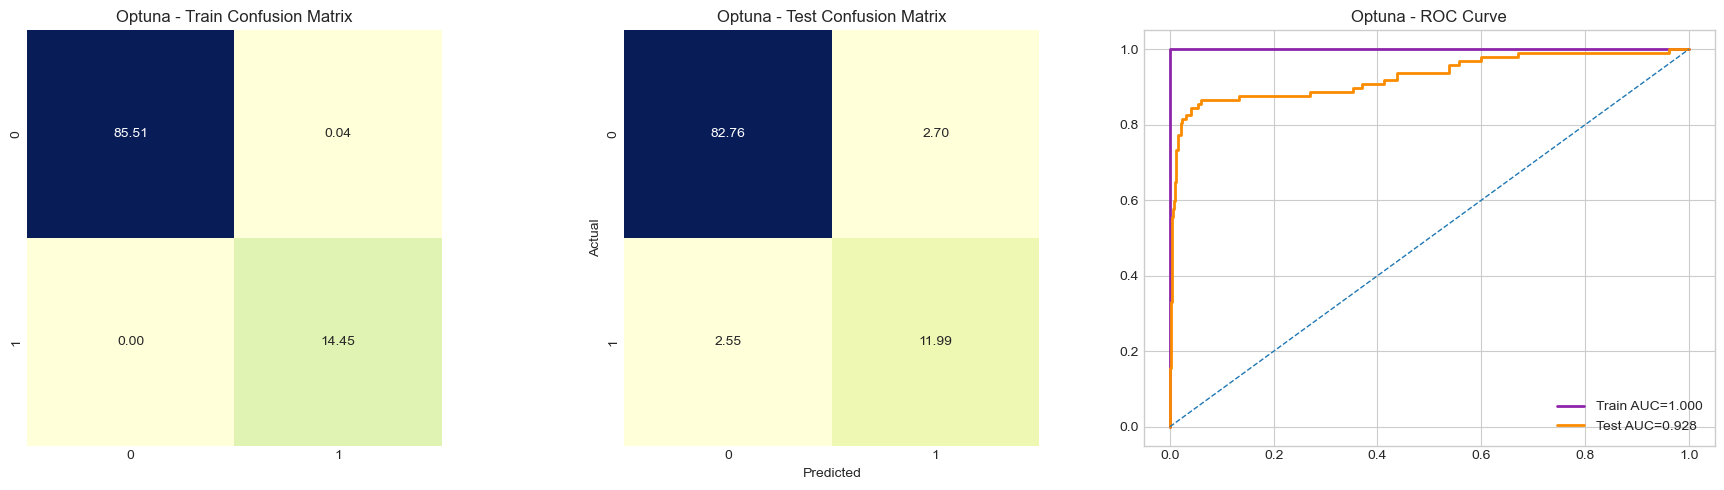

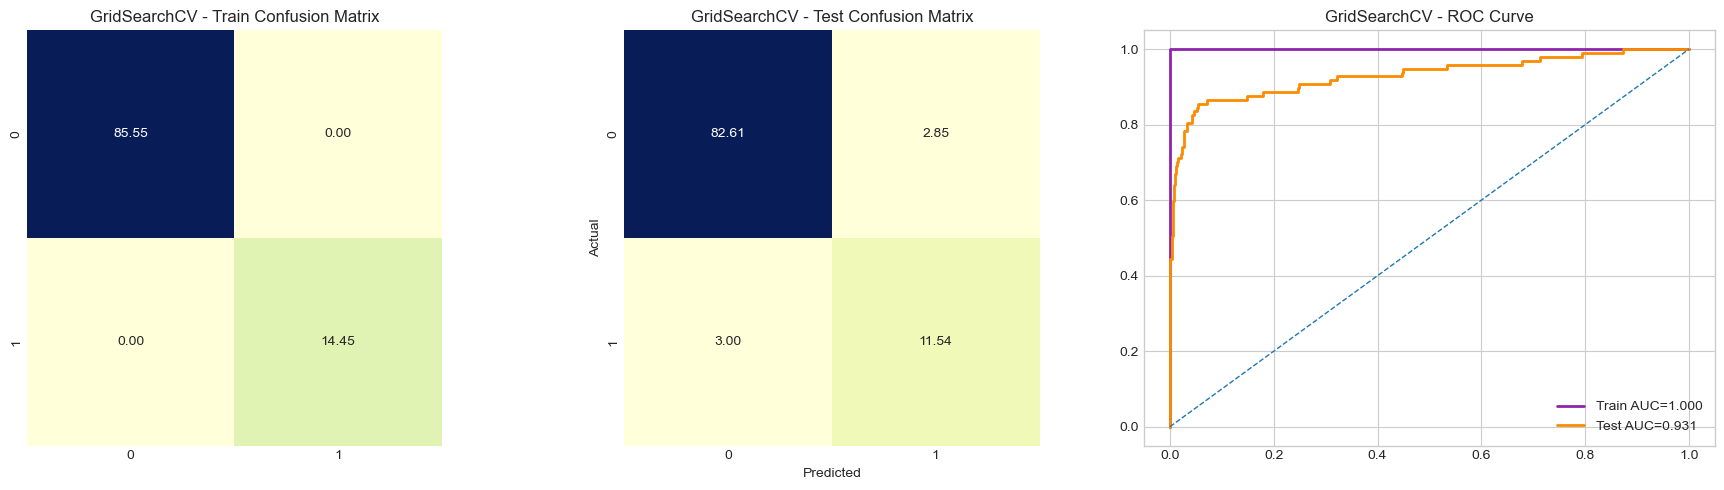

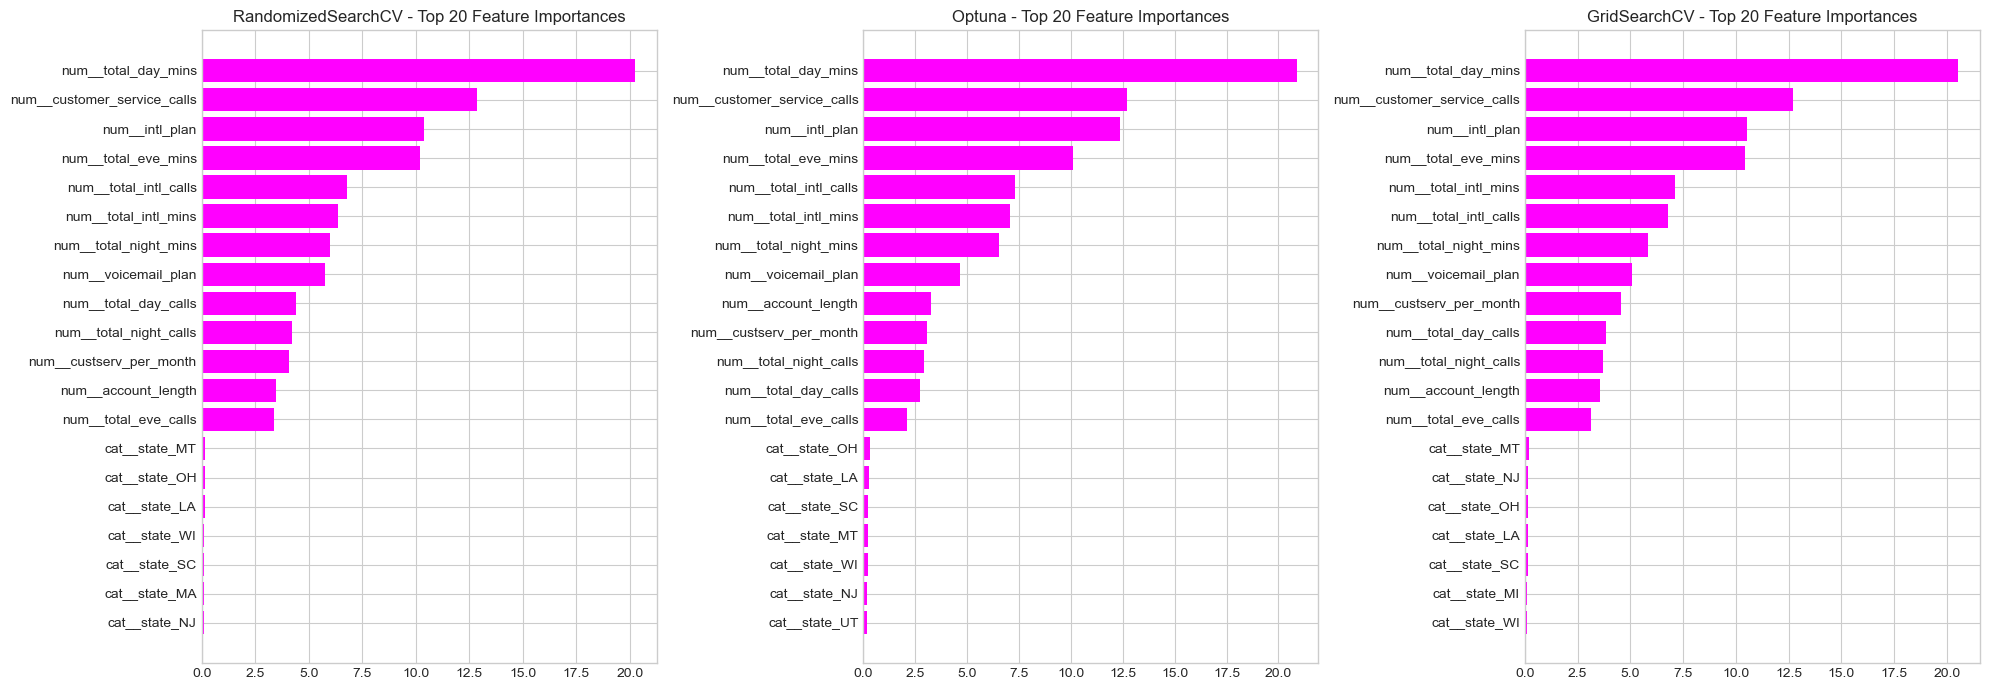

In [ ]:
# Class weights
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
class_weights = [1, scale_pos_weight] 

# Helpers — Metrics, ROC, Confusion Matrix
def compute_metrics(y_true, y_pred, y_prob):
    report = classification_report(y_true, y_pred, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_val = auc(fpr, tpr)

    metrics = {
        "accuracy": report["accuracy"],
        "precision": report["weighted avg"]["precision"],
        "recall": report["weighted avg"]["recall"],
        "f1": report["weighted avg"]["f1-score"],
        "roc_auc": roc_val
    }
    return metrics, cm, (fpr, tpr, roc_val)


# Evaluation function
def evaluate_model(pipeline, X_train, y_train, X_test, y_test, name):
    y_tr_pred = pipeline.predict(X_train)
    y_te_pred = pipeline.predict(X_test)
    y_tr_prob = pipeline.predict_proba(X_train)[:, 1]
    y_te_prob = pipeline.predict_proba(X_test)[:, 1]

    tr_metrics, tr_cm, tr_roc = compute_metrics(y_train, y_tr_pred, y_tr_prob)
    te_metrics, te_cm, te_roc = compute_metrics(y_test, y_te_pred, y_te_prob)

    metrics = {
        'Model': name,
        'Train Accuracy': tr_metrics['accuracy'],
        'Test Accuracy': te_metrics['accuracy'],
        'Train Precision': tr_metrics['precision'],
        'Test Precision': te_metrics['precision'],
        'Train Recall': tr_metrics['recall'],
        'Test Recall': te_metrics['recall'],
        'Train F1': tr_metrics['f1'],
        'Test F1': te_metrics['f1'],
        'Train ROC-AUC': tr_metrics['roc_auc'],
        'Test ROC-AUC': te_metrics['roc_auc']
    }

    model = pipeline.named_steps['model']

    # Feature importances
    try:
        feature_names = pipeline.named_steps['preprocess'].get_feature_names_out()
        importances = model.get_feature_importance()
        fi = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)
    except:
        fi = pd.Series([0]*pipeline.named_steps['preprocess'].transform(X_train).shape[1])

    return metrics, tr_cm, te_cm, tr_roc, te_roc, fi


# Base pipeline
base_pipe = Pipeline([
    ('preprocess', preprocessor),
    ('model', CatBoostClassifier(
        random_state=42,
        silent=True,
        eval_metric='Logloss',
        class_weights=class_weights
    ))
])

# Randomized search parameters
f1_scorer = make_scorer(f1_score, pos_label=1)

param_dist = {
    'model__iterations': [50, 150, 200, 250],
    'model__depth': [4, 6, 8],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__l2_leaf_reg': [1, 3, 5, 7],
    'model__bagging_temperature': [0.0, 0.3, 0.7]
}

rand_search = RandomizedSearchCV(
    base_pipe, param_distributions=param_dist, n_iter=30,
    cv=5, scoring=f1_scorer, random_state=42
)
rand_search.fit(X_train, y_train)
best_random = rand_search.best_params_

# Optuna tuning
def optuna_objective(trial):
    params = {
        'model__iterations': trial.suggest_categorical('iterations', [50, 150, 200, 250]),
        'model__depth': trial.suggest_categorical('depth', [2, 5, 8]),
        'model__learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'model__l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 10),
        'model__bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0)
    }

    pipe = Pipeline([
        ('preprocess', preprocessor),
        ('model', CatBoostClassifier(
            random_state=42,
            silent=True,
            eval_metric='Logloss',
            class_weights=class_weights
        ))
    ])
    pipe.set_params(**params)
    pipe.fit(X_train, y_train)

    preds = pipe.predict(X_test)
    return f1_score(y_test, preds)

study = optuna.create_study(direction='maximize')
study.optimize(optuna_objective, n_trials=30, show_progress_bar=True)

best_optuna = {f"model__{k}": v for k, v in study.best_params.items()}

# Grid search parameters
grid_params = {
    'model__iterations': [50, 100, 150, 200, 250],
    'model__depth': [2, 5, 8],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__l2_leaf_reg': [3, 5, 7],
    'model__bagging_temperature': [0.0, 0.3]
}

grid_search = GridSearchCV(base_pipe, param_grid=grid_params, cv=5, scoring=f1_scorer)
grid_search.fit(X_train, y_train)
best_grid = grid_search.best_params_

# BUILD FINAL MODELS
def build_pipeline(best_params):
    pipe = Pipeline([
        ('preprocess', preprocessor),
        ('model', CatBoostClassifier(
            random_state=42,
            silent=True,
            eval_metric='Logloss',
            class_weights=class_weights
        ))
    ])
    pipe.set_params(**best_params)
    pipe.fit(X_train, y_train)
    return pipe

models = {
    'RandomizedSearchCV': build_pipeline(best_random),
    'Optuna': build_pipeline(best_optuna),
    'GridSearchCV': build_pipeline(best_grid)
}

# Evaluation
results = {
    name: evaluate_model(model, X_train, y_train, X_test, y_test, name)
    for name, model in models.items()
}

metrics_df = pd.DataFrame([res[0] for res in results.values()])
display(metrics_df)

# Plots
def plot_separate_figures(results_dict):
    for name, res in results_dict.items():
        train_cm = res[1] / res[1].sum() * 100
        test_cm = res[2] / res[2].sum() * 100
        fpr_tr, tpr_tr, auc_tr = res[3]
        fpr_te, tpr_te, auc_te = res[4]

        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        sns.heatmap(train_cm, annot=True, fmt='.2f', cmap='YlGnBu',
                    cbar=False, square=True, ax=axes[0])
        axes[0].set_title(f'{name} - Train Confusion Matrix')
        axes[0].set_xlabel('Predicted')
        axes[0].set_ylabel('Actual')

        sns.heatmap(test_cm, annot=True, fmt='.2f', cmap='YlGnBu',
                    cbar=False, square=True, ax=axes[1])
        axes[1].set_title(f'{name} - Test Confusion Matrix')
        axes[1].set_xlabel('Predicted')
        axes[1].set_ylabel('Actual')

        axes[2].plot(fpr_tr, tpr_tr, lw=2, label=f'Train AUC={auc_tr:.3f}', color='#8e24aa')
        axes[2].plot(fpr_te, tpr_te, lw=2, label=f'Test AUC={auc_te:.3f}', color='#fb8c00')
        axes[2].plot([0, 1], [0, 1], '--', linewidth=1)
        axes[2].set_title(f'{name} - ROC Curve')
        axes[2].legend()

        plt.tight_layout()
        plt.show()

plot_separate_figures(results)

# Feature importance plots
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

for i, name in enumerate(['RandomizedSearchCV', 'Optuna', 'GridSearchCV']):
    fi = results[name][5].sort_values()
    axes[i].barh(fi.index, fi.values, color='magenta')
    axes[i].set_title(f'{name} - Top 20 Feature Importances')

plt.tight_layout()
plt.show()

### SAVE BEST MODEL AND TEST IT USING LIFT AND BUSINESS IMPACT

In [ ]:
# Build metrics DF
metrics_df = pd.DataFrame([res[0] for res in results.values()], index=results.keys())

# Choose based on Test F1
best_model_name = metrics_df['Test F1'].idxmax()

# Extract the best model from the models dict
best_model = models[best_model_name]

# Save best model
joblib.dump(best_model, "churn_pipeline.pkl")

print("Best model saved:", best_model_name)
metrics_df.loc[best_model_name]

Best model saved: Optuna


Model                Optuna
Train Accuracy     0.999625
Test Accuracy      0.947526
Train Precision    0.999626
Test Precision     0.947757
Train Recall       0.999625
Test Recall        0.947526
Train F1           0.999625
Test F1            0.947638
Train ROC-AUC           1.0
Test ROC-AUC        0.92845
Name: Optuna, dtype: object

In [ ]:
# Load model
loaded_model = joblib.load("churn_pipeline.pkl")

# Predictions
y_pred = loaded_model.predict(X_test)
y_prob = loaded_model.predict_proba(X_test)[:, 1]

# Combine actual vs predicted
comparison_df = pd.DataFrame({
    "Actual": y_test.reset_index(drop=True),
    "Predicted": y_pred,
    "Probability": y_prob
})

display(comparison_df.head(20)) 

,Actual,Predicted,Probability
0,1,1,0.985503
1,0,1,0.711103
2,0,0,0.460374
3,0,0,0.081181
4,0,0,0.045279
5,0,0,0.008408
6,0,0,0.005606
7,0,0,0.025683
8,0,0,0.007170
9,0,0,0.038762
